# Logistic model fit to oak data with sproc

HYBRID-DATA: https://docs.google.com/spreadsheets/d/13tOQniYpGp0Zhy-fvAiG-SRBLrSnSnK5DNfWhPztEzk/edit?usp=sharing

In [1]:
import itertools
import pandas as pd
import numpy as np
import toytree
import toyplot
import arviz as az
import pymc3 as pm

In [2]:
toyplot.config.autoformat = "png"

### Load tree and assign tips to clades

In [3]:
# exclude samples for reason xyz...
EXCLUDE = [
    'Quercus|Quercus|Leucomexicana|Q.species', 
    'Quercus|Quercus|Roburoids|Q.vulcanica',
    'Quercus|Quercus|Roburoids|Q.imeretina', 
    'Quercus|Lobatae|Erythromexicana|Q.lowilliamsii', 
    'Quercus|Lobatae|Agrifoliae|Q.oxyadenia',
    'Quercus|Quercus|Dumosae|Q.pacifica',
    'Quercus|Quercus|Roburoids|Q.kotschyana',
    'Quercus|Quercus|Roburoids|Q.cedrorum', 
    'Quercus|Lobatae|Agrifoliae|Q.tamalpaiensis',
    'Cerris|Cyclobalanopsis|Semiserrata|Q.litoralis', 
    'Cerris|Cyclobalanopsis|Semiserrata|Q.patelliformis',
    'Cerris|Cyclobalanopsis|Glauca|Q.multinervis', 
    'Cerris|Ilex|Himalayansubalpine|Q.sp.nov.',
]

In [4]:
TREE = toytree.tree("/home/henry/oaks-thesis/full_crown2.tre").drop_tips(EXCLUDE)

# find duplicates (label ends in 1 or 2, we'll drop the 2)
DUPS = [i for i in TREE.get_tip_labels() if i.endswith('2')]
TREE = TREE.drop_tips(DUPS)

# relabel kept duplicate tips by stripping 1 from end
TREE = TREE.set_node_values(
    feature="name", 
    values={nidx: TREE.idx_dict[nidx].name.strip("1") for nidx in TREE.idx_dict}
)

# Scale tree to 1.0 length
TREE = TREE.mod.node_scale_root_height(1.0)

In [5]:
# Get crown nodes for eight clades.
clades = [
    "Quercus|Quercus", # teal
    "Quercus|Virentes", # orange
    "Quercus|Ponticae", # blue
    "Quercus|Protobalanus", # pink
    "Quercus|Lobatae", # green
    "Cerris|Ilex", # yellow
    "Cerris|Cerris", # tan
    "Cerris|Cyclobalanopsis", # gray
]
crowns = {
    TREE.get_mrca_idx_from_tip_labels(wildcard=i): i for i in clades
}
crowns

{419: 'Quercus|Quercus',
 420: 'Quercus|Virentes',
 434: 'Quercus|Ponticae',
 447: 'Quercus|Protobalanus',
 455: 'Quercus|Lobatae',
 450: 'Cerris|Ilex',
 451: 'Cerris|Cerris',
 457: 'Cerris|Cyclobalanopsis'}

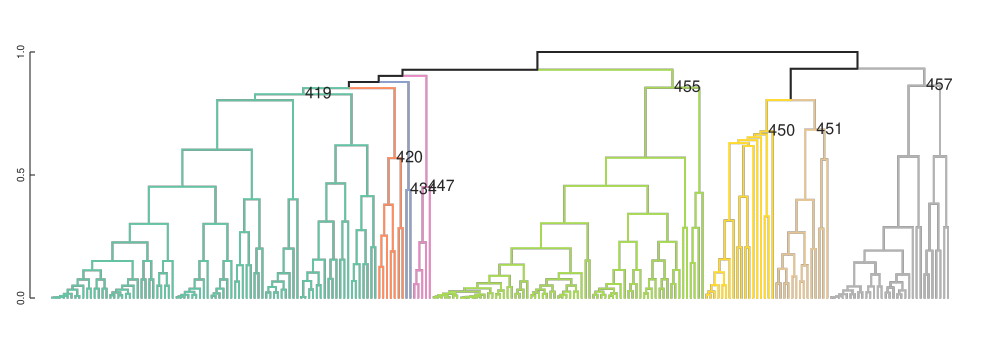

In [102]:
# draw the tree
TREE.draw(
    layout='d', 
    edge_colors=TREE.get_edge_values_mapped({
            j: toytree.colors[i] for i,j in enumerate(crowns)
        }),
    tip_labels=False,
    height=350,
    node_labels=[
        str(i) if int(i) in crowns else "" 
        for i in TREE.get_node_values("idx", 1, 1)
    ],
    node_labels_style={
        "font-size": "16px",
        "-toyplot-anchor-shift": "15px",
    },
    scalebar = True
);

### Load hybrid crossing data

In [23]:
# load datasets
data = pd.read_csv('/home/henry/oaks-thesis/csv-files/oak-hybrid-5.6.21.csv')
data = data.loc[data.exclude != 1, :]
data

,speciesA,speciesB,author,datatype,hybrid,exclude,notes,overlap,records
0,alba,bicolor,Trelease 1917,morphology,1,NaN,NaN,NaN,NaN
1,alba,macrocarpa,Trelease 1917,morphology,1,NaN,NaN,NaN,NaN
2,alba,montana,Trelease 1917,morphology,1,NaN,NaN,NaN,NaN
3,alba,muehlenbergii,Trelease 1917,morphology,1,NaN,NaN,NaN,NaN
4,alba,prinoides,Trelease 1917,morphology,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2105,conzattii,vaseyana,sproc,sproc,0,NaN,NaN,NaN,NaN
2106,conzattii,pungens,sproc,sproc,0,NaN,NaN,NaN,NaN
2107,conzattii,laceyi,sproc,sproc,0,NaN,NaN,NaN,NaN
2108,conzattii,polymorpha,sproc,sproc,0,NaN,NaN,NaN,NaN


In [24]:
# record RI as inverse of hybrid
data["RI"] = abs(data.hybrid - 1)

# subsample to relevant columns
data = data.loc[:, ["speciesA", "speciesB", "RI"]]

In [25]:
# order names alphabetically
for idx in data.index:
    if data.speciesA[idx] > data.speciesB[idx]:
        _a = data.loc[idx, 'speciesA']
        _b = data.loc[idx, 'speciesB']
        data.loc[idx, 'speciesA'] = _b
        data.loc[idx, 'speciesB'] = _a

In [26]:
# remove any duplicated records
data = data.drop_duplicates(subset=['speciesA', 'speciesB'])

In [27]:
# translate tip names in data to idx in TREE (sidx)
transform = {
    TREE.idx_dict[nidx].name.split("|")[-1][2:]: nidx 
    for nidx in TREE.idx_dict 
    if TREE.idx_dict[nidx].is_leaf()
}
data['sidx0'] = [transform.get(i, pd.NA) for i in data.speciesA.tolist()]
data['sidx1'] = [transform.get(i, pd.NA) for i in data.speciesB.tolist()]

In [28]:
data.head()

,speciesA,speciesB,RI,sidx0,sidx1
0,alba,bicolor,0,52,47
1,alba,macrocarpa,0,52,49
2,alba,montana,0,52,54
3,alba,muehlenbergii,0,52,50
4,alba,prinoides,0,52,51


In [29]:
# find any rows that have NA (species not in TREE)
missing = set(data.speciesA[data.sidx0.isna()].unique())
missing.update(set(data.speciesB[data.sidx1.isna()].unique()))
missing

{'cornelius‐mulleri'}

In [30]:
# drop any rows containing an NA value
data = data.loc[data.sidx0.notna() & data.sidx1.notna(), :].reset_index(drop=True)
data.sidx0 = data.sidx0.astype(int)
data.sidx1 = data.sidx1.astype(int)

In [31]:
# get 1-scaled genetic distances between pairs
def get_dist(tree, idx0, idx1):
    "returns the genetic distance between two nodes on a tree"
    dist = tree.treenode.get_distance(
        tree.idx_dict[idx0], 
        tree.idx_dict[idx1],
    )
    return dist

data['dist'] = [get_dist(TREE, i, j) / 2 for (i, j) in zip(data.sidx0, data.sidx1)]

In [32]:
# add RI=0 for all within-species comparisons
idx = data.shape[0]
for nidx in range(TREE.ntips):
    node = TREE.idx_dict[nidx]
    name = node.name.split("|")[-1][2:]
    data.loc[idx] = name, name, 0, nidx, nidx, 0.0
    idx += 1

In [33]:
# add normalized dist
data['normdist'] = ((data['dist'] - data['dist'].mean()) / data['dist'].std())

In [34]:
data

,speciesA,speciesB,RI,sidx0,sidx1,dist,normdist
0,alba,bicolor,0,52,47,0.401786,-1.109744
1,alba,macrocarpa,0,52,49,0.401786,-1.109744
2,alba,montana,0,52,54,0.200893,-1.723353
3,alba,muehlenbergii,0,52,50,0.401786,-1.109744
4,alba,prinoides,0,52,51,0.401786,-1.109744
...,...,...,...,...,...,...,...
2264,rex,rex,0,226,226,0.000000,-2.336962
2265,chungii,chungii,0,227,227,0.000000,-2.336962
2266,delavayi,delavayi,0,228,228,0.000000,-2.336962
2267,championii,championii,0,229,229,0.000000,-2.336962


In [35]:
# make group index (gidx)
crown_dict = {i: TREE.get_tip_labels(i) for i in crowns}
gidx = np.zeros(TREE.ntips, dtype=int)
for tidx, tip in enumerate(TREE.get_tip_labels()):
    for cidx, clade in enumerate(crown_dict):
        if tip in crown_dict[clade]:
            gidx[tidx] = cidx
gidx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

### VISUALIZE THE HYBRID CROSSING DATA

In [36]:
def heatmap_plot(TREE, CLADES, data, **kwargs):
    """
    Sanity check: does the data make sense?
    """
    # get canvas size
    canvas = toyplot.Canvas(
        width=kwargs.get('width', 600),
        height=kwargs.get('height', 600),
    );

    # add tree to canvas
    ax0 = canvas.cartesian(
        bounds=("5%", "25%", "5%", "95%"),
        show=False
    )
    TREE.draw(
        axes=ax0, 
        layout='r', 
        tip_labels=False,
        edge_colors=TREE.get_edge_values_mapped({
            j: toytree.colors[i] for i,j in enumerate(CLADES)
        })
    )
    NSPECIES = TREE.ntips

    # add heatmap to canvas
    ax1 = canvas.table(
        rows=NSPECIES, 
        columns=NSPECIES, 
        bounds=("27%", "95%", "5%", "95%"),
        margin=20
    )
    ax1.cells.cell[:].style = {
        "fill": 'lightgrey',
        "stroke": "none"
    }

    # set values for data
    for idx in data.index:
        ridx, cidx = data.loc[idx, ['sidx0', 'sidx1']]
        rridx = NSPECIES - ridx - 1
        ccidx = NSPECIES - cidx - 1
        ridx, cidx, rridx, ccidx = [
            int(i) for i in (ridx, cidx, rridx, ccidx)
        ]

        # get RI for this cell
        value = data.loc[idx, 'RI']
        if value:
            color = "red"
        else:
            color = "black"
        
        ax1.cells.cell[rridx, cidx].style = {
            "fill": color,
            "stroke": "none"
        }
        ax1.cells.cell[ccidx, ridx].style = {
            "fill": color,
            "stroke": "none"
        }

    # dividers
    ax1.body.gaps.columns[...] = 0.
    ax1.body.gaps.rows[...] = 0.
    
    return canvas

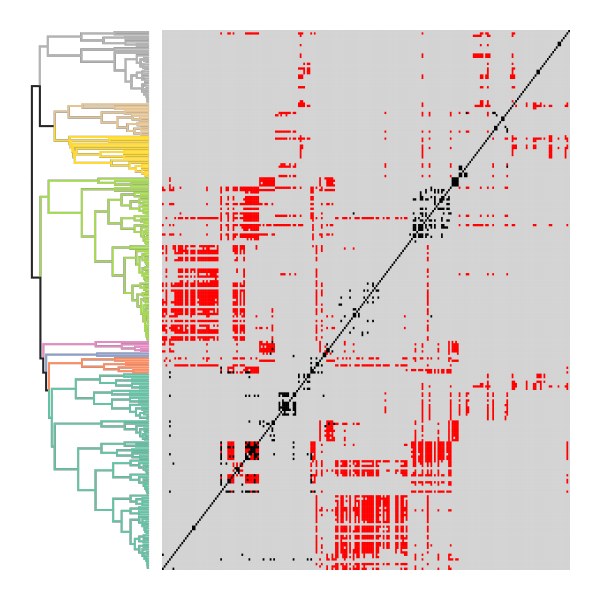

In [37]:
predata = heatmap_plot(TREE, crown_dict, data)

In [87]:
toyplot.png.render(predata, "/home/henry/png/predata.png")

In [38]:
def dist_RI_scatterplot(TREE, data, jitter=0.01):
    """
    Scatterplot of RI values x genetic dist with the 
    genetic distance values jittered slightly to show
    more clearly despite overlap.
    """
    canvas = toyplot.Canvas(width=300, height=300)
    axes = canvas.cartesian(
        xlabel="Genetic dist.",
        ylabel="Reproductive isolation",
    )
    ns = sum(data.RI == 0)
    xs = data.dist[data.RI == 0] + np.random.uniform(-jitter, jitter, size=ns)
    xs[xs > 1] = 1
    xs[xs < 0] = 0    
    mark = axes.scatterplot(
        xs,
        data.RI[data.RI == 0],
        size=10,
        opacity=0.1,
        marker="|",
        mstyle={
            "stroke": 'black',
            "stroke-width": 3,
        },
    );
    ns = sum(data.RI == 1)
    xs = data.dist[data.RI == 1] + np.random.uniform(-jitter, jitter, size=ns)
    xs[xs > 1] = 1
    xs[xs < 0] = 0
    mark = axes.scatterplot(
        xs,
        data.RI[data.RI == 1],
        size=10,
        opacity=0.1,
        marker="|",
        mstyle={
            "stroke": 'red',
            "stroke-width": 3,
        },
    );
    axes.x.ticks.show = True
    axes.y.ticks.show = True
    return canvas, axes, mark

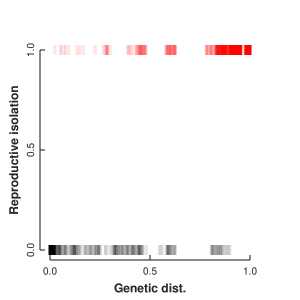

In [88]:
plotc, plota, plotm = dist_RI_scatterplot(TREE, data, jitter=0.025);

In [89]:
toyplot.png.render(plotc, "/home/henry/png/dist_RI_scatterplot.png")

In [40]:
data[data.RI == 0].sort_values(by='dist', ascending=False).head(10)

,speciesA,speciesB,RI,sidx0,sidx1,dist,normdist
139,cedrosensis,engelmannii,0,97,62,0.902643,0.420078
140,engelmannii,tomentella,0,62,94,0.902643,0.420078
193,pontica,robur,0,91,74,0.877875,0.344427
192,garryana,sadleriana,0,61,92,0.877875,0.344427
88,stellata,virginiana,0,33,84,0.853107,0.268776
109,minima,stellata,0,86,33,0.853107,0.268776
106,margarettae,virginiana,0,37,84,0.853107,0.268776
105,austrina,virginiana,0,38,84,0.853107,0.268776
51,sinuata,virginiana,0,40,84,0.853107,0.268776
176,turbinella,virginiana,0,4,84,0.853107,0.268776


### Fit models

In [41]:
def toytrace(trace, var_names, titles):
    """
    Plot posterior trace with toyplot
    """
    nvars = len(var_names)
    
    # setup canvase
    canvas = toyplot.Canvas(width=500, height=200 * nvars)
    
    # store axes
    axes = []
    
    # iter over params
    for pidx, param in enumerate(var_names):
        
        # get param posterior
        posterior = trace.get_values(param)
        
        # setup axes 
        ax = canvas.cartesian(grid=(nvars, 1, pidx))
        ax.y.show = False
        ax.x.spine.style = {"stroke-width": 1.5}
        ax.x.ticks.labels.style = {"font-size": "12px"}
        ax.x.ticks.show = True
        ax.x.label.text = f"param='{titles[pidx]}'"        
        
        # iterate over shape of param
        for idx in range(posterior.shape[1]):
            mags, bins = np.histogram(posterior[:, idx], bins=100)
            ax.plot(bins[1:], mags, stroke_width=2, opacity=0.6)
        axes.append(ax)
    return canvas, axes

In [42]:
def partpooled_linear(x, y, idx0, idx1, gidx, **kwargs):
    
    # define model
    with pm.Model() as model:
        
        # indexers
        sidx0 = pm.Data("spp_idx0", idx0)
        sidx1 = pm.Data("spp_idx1", idx1)
        gidx = pm.Data("gidx", gidx)

        # parameters and error
        𝜓_mean = pm.Normal('𝜓_mean', mu=0., sigma=5., shape=len(crowns))
        𝜓_std = pm.HalfNormal('𝜓_std', 5., shape=len(crowns))
        𝜓_offset = pm.Normal('𝜓_offset', mu=0, sigma=1., shape=TREE.ntips)
        𝜓 = pm.Deterministic('𝜓', 𝜓_mean[gidx] + 𝜓_std[gidx] * 𝜓_offset)
        𝛽 = pm.Normal('𝛽', mu=0., sigma=10., shape=1)
        𝛼 = pm.Normal('𝛼', mu=0., sigma=10., shape=1)
        
        # linear model prediction
        effect = 𝛼 + (𝛽 + 𝜓[sidx0] + 𝜓[sidx1]) * x
        logit = pm.Deterministic("logit", pm.invlogit(effect))
        
        # data likelihood (normal distributed errors)
        y_like = pm.Bernoulli("y", p=logit, observed=y)
        
        # sample posterior, skip burnin
        trace = pm.sample(**kwargs)[1000:]

        # show summary table
        stats = pm.summary(trace)
        
    # organize results
    result_dict = {
        'model': model, 
        'trace': trace,
        'stats': stats,
    }
    return result_dict

In [43]:
def partpooled_logarithmic(x, y, idx0, idx1, gidx, **kwargs):
    
    # define model
    with pm.Model() as model:
        
        # indexers
        sidx0 = pm.Data("spp_idx0", idx0)
        sidx1 = pm.Data("spp_idx1", idx1)
        gidx = pm.Data("gidx", gidx)

        # parameters and error
        𝜓_mean = pm.Normal('𝜓_mean', mu=0., sigma=5., shape=len(crowns))
        𝜓_std = pm.HalfNormal('𝜓_std', 5., shape=len(crowns))
        𝜓_offset = pm.Normal('𝜓_offset', mu=0, sigma=1., shape=TREE.ntips)
        𝜓 = pm.Deterministic('𝜓', 𝜓_mean[gidx] + 𝜓_std[gidx] * 𝜓_offset)
        𝛽 = pm.Normal('𝛽', mu=0., sigma=10., shape=1)
        𝛼 = pm.Normal('𝛼', mu=0., sigma=10., shape=1)
        
        # linear model prediction
        effect = 𝛼 + (𝛽 + 𝜓[sidx0] + 𝜓[sidx1]) * np.log(1 + x)
        logit = pm.Deterministic("logit", pm.invlogit(effect))
        
        # data likelihood (normal distributed errors)
        y_like = pm.Bernoulli("y", p=logit, observed=y)
        
        # sample posterior, skip burnin
        trace = pm.sample(**kwargs)[1000:]

        # show summary table
        stats = pm.summary(trace)
        
    # organize results
    result_dict = {
        'model': model, 
        'trace': trace,
        'stats': stats,
    }
    return result_dict

In [44]:
def partpooled_exponential(x, y, idx0, idx1, gidx, **kwargs):
    
    # define model
    with pm.Model() as model:
        
        # indexers
        sidx0 = pm.Data("spp_idx0", idx0)
        sidx1 = pm.Data("spp_idx1", idx1)
        gidx = pm.Data("gidx", gidx)

        # parameters and error
        𝜓_mean = pm.Normal('𝜓_mean', mu=0., sigma=5., shape=len(crowns))
        𝜓_std = pm.HalfNormal('𝜓_std', 5., shape=len(crowns))
        𝜓_offset = pm.Normal('𝜓_offset', mu=0, sigma=1., shape=TREE.ntips)
        𝜓 = pm.Deterministic('𝜓', 𝜓_mean[gidx] + 𝜓_std[gidx] * 𝜓_offset)
        𝛽 = pm.Normal('𝛽', mu=0.5, sigma=10., shape=1)
        𝛼 = pm.Normal('𝛼', mu=0., sigma=10., shape=1)
        
        # linear model prediction
        effect = 𝛼 * ((𝛽 + 𝜓[sidx0] + 𝜓[sidx1]) ** x)
        logit = pm.Deterministic("logit", pm.invlogit(effect))
        
        # data likelihood (normal distributed errors)
        y_like = pm.Bernoulli("y", p=logit, observed=y)
        
        # sample posterior, skip burnin
        trace = pm.sample(init = 'adapt_diag', **kwargs)[1000:]

        # show summary table
        stats = pm.summary(trace)
        
    # organize results
    result_dict = {
        'model': model, 
        'trace': trace,
        'stats': stats,
    }
    return result_dict

In [45]:
def partpooled_asymptotic(x, y, idx0, idx1, gidx, **kwargs):
    
    # define model
    with pm.Model() as model:
        
        # indexers
        sidx0 = pm.Data("spp_idx0", idx0)
        sidx1 = pm.Data("spp_idx1", idx1)
        gidx = pm.Data("gidx", gidx)

        # parameters and error
        𝜓_mean = pm.Normal('𝜓_mean', mu=0., sigma=5., shape=len(crowns))
        𝜓_std = pm.HalfNormal('𝜓_std', 5., shape=len(crowns))
        𝜓_offset = pm.Normal('𝜓_offset', mu=0, sigma=1., shape=TREE.ntips)
        𝜓 = pm.Deterministic('𝜓', 𝜓_mean[gidx] + 𝜓_std[gidx] * 𝜓_offset)
        𝛽 = pm.Normal('𝛽', mu=0., sigma=10., shape=1)
        𝛼 = pm.Normal('𝛼', mu=0., sigma=10., shape=1)
        
        # linear model prediction
        effect = 1 - (1 -𝛼) * np.exp(-(𝛽 + 𝜓[sidx0] + 𝜓[sidx1]) * x)
        logit = pm.Deterministic("logit", pm.invlogit(effect))
        
        # data likelihood (normal distributed errors)
        y_like = pm.Bernoulli("y", p=logit, observed=y)
        
        # sample posterior, skip burnin
        trace = pm.sample(**kwargs)[1000:]

        # show summary table
        stats = pm.summary(trace)
        
    # organize results
    result_dict = {
        'model': model, 
        'trace': trace,
        'stats': stats,
    }
    return result_dict

In [46]:
def partpooled_quadratic(x, y, idx0, idx1, gidx, **kwargs):
    
    # define model
    with pm.Model() as model:
        
        # indexers
        sidx0 = pm.Data("spp_idx0", idx0)
        sidx1 = pm.Data("spp_idx1", idx1)
        gidx = pm.Data("gidx", gidx)

        # parameters and error
        𝜓_mean = pm.Normal('𝜓_mean', mu=0., sigma=5., shape=len(crowns))
        𝜓_std = pm.HalfNormal('𝜓_std', 5., shape=len(crowns))
        𝜓_offset = pm.Normal('𝜓_offset', mu=0, sigma=1., shape=TREE.ntips)
        𝜓 = pm.Deterministic('𝜓', 𝜓_mean[gidx] + 𝜓_std[gidx] * 𝜓_offset)
        𝛽 = pm.Normal('𝛽', mu=0., sigma=10., shape=1)
        𝛼 = pm.Normal('𝛼', mu=0., sigma=10., shape=1)
        
        # linear model prediction
        effect = ((𝛽 + 𝜓[sidx0] + 𝜓[sidx1]) * x ** 2) + 𝛼 * x
        logit = pm.Deterministic("logit", pm.invlogit(effect))
        
        # data likelihood (normal distributed errors)
        y_like = pm.Bernoulli("y", p=logit, observed=y)
        
        # sample posterior, skip burnin
        trace = pm.sample(**kwargs)[1000:]

        # show summary table
        stats = pm.summary(trace)
        
    # organize results
    result_dict = {
        'model': model, 
        'trace': trace,
        'stats': stats,
    }
    return result_dict

In [47]:
# MCMC sampler kwargs
sample_kwargs = dict(
    tune=10000,
    draws=10000,
    target_accept=0.99,
    return_inferencedata=False,
    progressbar=True,
)

In [48]:
# model input
model_args = [
    data.dist,
    data.RI,
    data.sidx0,
    data.sidx1,
    gidx,
]

In [49]:
linear = partpooled_linear(*model_args, **sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝛼, 𝛽, 𝜓_offset, 𝜓_std, 𝜓_mean]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 5758 seconds.


In [50]:
logarithmic = partpooled_logarithmic(*model_args, **sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝛼, 𝛽, 𝜓_offset, 𝜓_std, 𝜓_mean]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 2851 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [51]:
exponential = partpooled_exponential(*model_args, **sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝛼, 𝛽, 𝜓_offset, 𝜓_std, 𝜓_mean]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 6411 seconds.
There were 9932 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9137 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 9973 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9866 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
asymptotic = partpooled_asymptotic(*model_args, **sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝛼, 𝛽, 𝜓_offset, 𝜓_std, 𝜓_mean]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [52]:
quadratic = partpooled_quadratic(*model_args, **sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝛼, 𝛽, 𝜓_offset, 𝜓_std, 𝜓_mean]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 8732 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [84]:
az_linear = az.from_pymc3(trace = linear['trace'], model = linear['model'])
az_logarithmic = az.from_pymc3(trace = logarithmic['trace'], model = logarithmic['model'])
az_exponential = az.from_pymc3(trace = exponential['trace'], model = exponential['model'])
az_asymptotic = az.from_pymc3(trace = asymptotic['trace'], model = asymptotic['model'])
az_quadratic = az.from_pymc3(trace = quadratic['trace'], model = quadratic['model'])

In [85]:
az.compare({"linear": az_linear,
            "logarithmic": az_logarithmic, 
            "exponential": az_exponential,
           "asymptotic": az_asymptotic,
           "quadratic": az_quadratic})

/home/henry/miniconda3/envs/py37/lib/python3.7/site-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
/home/henry/miniconda3/envs/py37/lib/python3.7/site-packages/arviz/stats/stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/home/henry/miniconda3/envs/py37/lib/python3.7/site-packages/arviz/stats/stats.py:684: Use

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
linear,0,-187.931,38.4925,0,0.997024,19.5687,0,True,log
logarithmic,1,-194.926,37.9795,6.99485,0.00297576,20.1303,1.51744,True,log
quadratic,2,-324.038,38.7753,136.107,1.98586e-41,24.902,14.2648,True,log
exponential,3,-446.293,7.2573,258.362,2.04718e-88,16.9321,19.2832,False,log
asymptotic,4,-616.849,7.17675,428.918,2.54428e-154,17.7866,27.0888,True,log


### Examine linear model results

In [56]:
linear['stats'].head(10)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
𝜓_mean[0],-0.031,1.889,-3.542,3.580,0.014,0.010,18727.0,18727.0,18730.0,22641.0,1.0
𝜓_mean[1],-0.392,2.334,-4.941,3.845,0.015,0.011,24816.0,22049.0,24741.0,25653.0,1.0
𝜓_mean[2],-3.152,2.930,-8.737,2.436,0.016,0.012,33008.0,28631.0,33149.0,27307.0,1.0
𝜓_mean[3],0.807,2.332,-3.522,5.306,0.015,0.010,25194.0,24738.0,25109.0,26884.0,1.0
𝜓_mean[4],1.239,1.853,-2.188,4.742,0.014,0.010,18720.0,18720.0,18725.0,22916.0,1.0
𝜓_mean[5],2.405,2.746,-2.729,7.567,0.016,0.012,29555.0,27625.0,29592.0,28852.0,1.0
𝜓_mean[6],0.149,2.267,-4.078,4.403,0.015,0.010,23539.0,23539.0,23511.0,26633.0,1.0
𝜓_mean[7],5.093,3.333,-0.892,11.535,0.017,0.013,38990.0,30624.0,40674.0,28260.0,1.0
𝜓_offset[0],0.233,0.849,-1.320,1.814,0.003,0.005,65842.0,16432.0,72086.0,25203.0,1.0
𝜓_offset[1],0.221,0.862,-1.353,1.847,0.003,0.005,68148.0,15870.0,73235.0,25700.0,1.0


In [69]:
names = ["Quercus " + TREE.get_tip_labels()[idx].split("|")[-1].split(".")[-1] for idx in range(len(TREE.get_tip_labels()))]

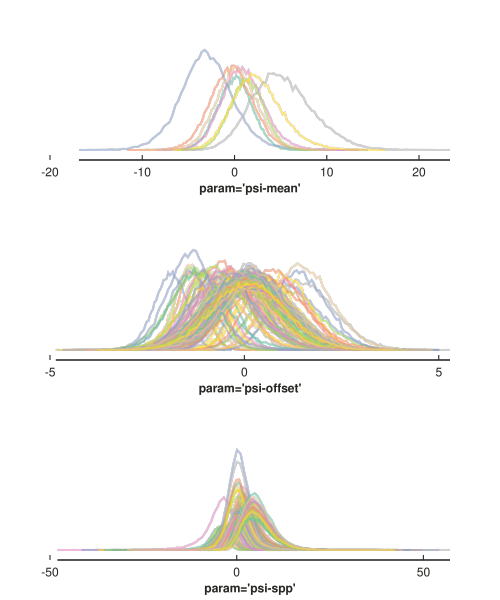

In [90]:
tracec, tracea = toytrace(linear['trace'], ['𝜓_mean', '𝜓_offset', '𝜓'], ['psi-mean', 'psi-offset', 'psi-spp']);

In [91]:
toyplot.png.render(tracec, "/home/henry/png/toytrace.png")

In [58]:
import scipy.stats as stats

def draw_velocity_dists(trace, baseline=0.15):
    """
    Draw the clade velocities as gaussians
    """
    canvas = toyplot.Canvas(width=350, height=300)
    axes = canvas.cartesian(xlabel="Relative velocity of reproductive isolation")
    marks = []
    base = 0
    for i in range(trace['𝜓_mean'].shape[1]):
        
        loc = trace['𝜓_mean'][:, i].mean()
        scale = trace['𝜓_std'][:, i].mean()
        interval = stats.norm.interval(0.995, loc, scale)
        points = np.linspace(interval[0], interval[1], 100)
        mark = axes.fill(
            points, 
            stats.norm.pdf(points, loc=loc, scale=scale), 
            style={
                "fill-opacity": 0.45,
                "stroke": 'black',
                "stroke-opacity": 1.0,
                "stroke-width": 1,
            },
            baseline=np.repeat(base, 100),
        )
        marks.append(mark)
        axes.hlines(base, style={"stroke-dasharray": "5,5", 'stroke-width': 1})
        base += baseline
        
    axes.y.show = False
    axes.x.ticks.locator = toyplot.locator.Extended(only_inside=True)
    axes.x.ticks.show = True
    return canvas, axes, marks

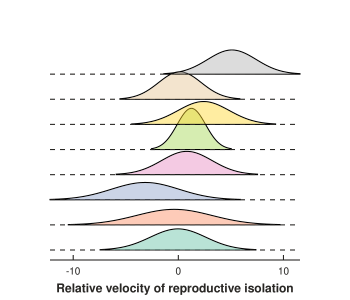

In [92]:
veloc, veloa, velom = draw_velocity_dists(linear['trace'], baseline=0.18);

In [93]:
toyplot.png.render(veloc, "/home/henry/png/velocity_dists.png")

### RESULT FIGURES

In [96]:
linear['trace'].varnames

['𝜓_mean', '𝜓_std_log__', '𝜓_offset', '𝛽', '𝛼', '𝜓_std', '𝜓', 'logit']

In [60]:
a, b = zip(*itertools.combinations(range(TREE.ntips), 2))
post = pd.DataFrame({
    "sidx0": a,
    "sidx1": b,
    "dist": [get_dist(TREE, i, j) / 2. for (i, j) in zip(a, b)],
})
psi_means = linear['trace']['𝜓'].mean(axis=0)
post["RI"] = (
    linear['trace']['𝛼'].mean() + [
        linear['trace']['𝛽'].mean() + psi_means[i] + psi_means[j] 
        for (i, j) in zip(a, b)
    ] * post['dist']
)
post["RI"] = 1 / (1 + np.exp(-(post["RI"])))
post.head()

,sidx0,sidx1,dist,RI
0,0,1,0.001046,0.003810
1,0,2,0.002093,0.003866
2,0,3,0.004185,0.003968
3,0,4,0.008371,0.004064
4,0,5,0.016741,0.004720


In [61]:
def dist_RI_results_scatterplot(data, jitter=0.01):
    """
    Scatterplot of RI values x genetic dist with the 
    genetic distance values jittered slightly to show
    more clearly despite overlap.
    """
    canvas = toyplot.Canvas(width=300, height=300)
    axes = canvas.cartesian(
        label="logit sigmoid function fit to data",
        xlabel="Genetic distance",
        ylabel="Probability of RI",
    )
    mark = axes.scatterplot(
        data.dist + np.random.uniform(-jitter, jitter, size=data.dist.size),
        data.RI,
        size=8,
        opacity=0.1,
        mstyle={
            "stroke": "none",
            "fill": '#262626',
            "fill-opacity": 0.33,
        },
    );
    axes.x.ticks.show = True
    axes.y.ticks.show = True
    return canvas, axes, mark

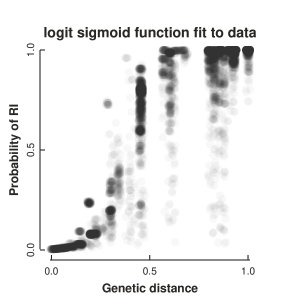

In [94]:
rm, ra, rc = dist_RI_results_scatterplot(post);

In [95]:
toyplot.png.render(rm, "/home/henry/png/dist_RI_results.png")

In [63]:
def heat_results_plot(TREE, CLADES, results):
    
    # get canvas size
    canvas = toyplot.Canvas(width=500, height=500);

    # colormap for values between 0-1
    cmap_lower = toyplot.color.LinearMap(
        domain_min=results.RI.min(), 
        domain_max=results.RI.max()
    )

    # add tree to canvas
    ax0 = canvas.cartesian(
        bounds=("5%", "25%", "5%", "95%"),
        show=False
    )
    TREE.draw(
        axes=ax0, 
        layout='r', 
        tip_labels=False,
        edge_colors=TREE.get_edge_values_mapped({
            j: toytree.colors[i] for i,j in enumerate(CLADES)
        })
    )
    NSPECIES = TREE.ntips

    # add heatmap to canvas
    ax1 = canvas.table(
        rows=NSPECIES, 
        columns=NSPECIES, 
        bounds=("27%", "88%", "5%", "95%"),
        margin=20
    )
    ax1.cells.cell[:].style = {
        "fill": 'lightgrey',
        "stroke": "none"
    }

    # set values for data
    for idx in results.index:
        ridx, cidx = results.loc[idx, ['sidx0', 'sidx1']]
        rridx = NSPECIES - ridx - 1
        ccidx = NSPECIES - cidx - 1
        ridx, cidx, rridx, ccidx = [
            int(i) for i in (ridx, cidx, rridx, ccidx)
        ]

        # get RI for this cell
        value = results.at[idx, 'RI']
        
        # fill below diagonal with logit
        ax1.cells.cell[rridx, cidx].style = {
            "fill": cmap_lower.color(value),
            "stroke": "none"
        }
        
        # randomly sample RI using logit probability for color
        if np.random.binomial(1, results.at[idx, "RI"]):
            fill = "white"
        else:
            fill = "black"

        # fill above diagonal with sampled RI 
        ax1.cells.cell[ccidx, ridx].style = {
            "fill": fill,
            "stroke": "none"
        }

    for idx in range(NSPECIES):
        ax1.cells.cell[NSPECIES - idx - 1, idx].style = {
            "fill": cmap_lower.color(0),
            "stroke": "none"
        }

    # dividers
    ax1.body.gaps.columns[...] = 0.0
    ax1.body.gaps.rows[...] = 0.0
    
    # add a colorbar
    numberline = canvas.numberline("92%", "95%", "92%", "5%")
    numberline.colormap(cmap_lower, style={"stroke-width": 5})

    return canvas

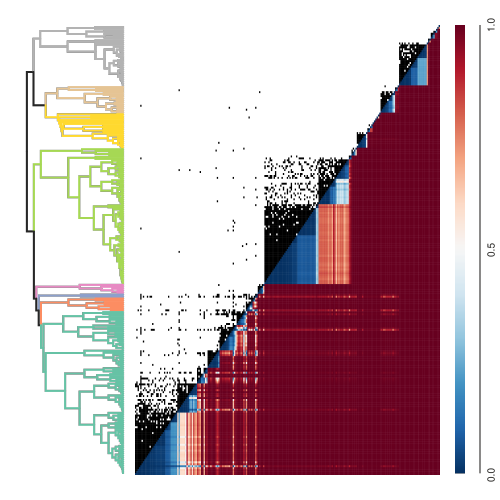

In [96]:
heatmap = heat_results_plot(TREE, crowns, post)

In [97]:
toyplot.png.render(heatmap, "/home/henry/png/heatmap.png")

### Rates on tree
This figure could be made much prettier...

In [65]:
psi_means = linear['trace']['𝜓'].mean(axis=0)

In [66]:
def plot_tree_rates(TREE, CLADES, values, **kwargs):
    
    # get canvas size
    canvas = toyplot.Canvas(
        width=kwargs.get('width', 500),
        height=kwargs.get('height', 500),
    )
    
    # colormap for values between 0-1
    cmap_lower = toyplot.color.LinearMap(
        domain_min=values.min(), 
        domain_max=values.max()
    )
    
    # add tree to canvas
    ax0 = canvas.cartesian(
        bounds=("10%", "40%", "5%", "85%"),
        show=False
    )
    TREE.draw(
        axes=ax0, 
        layout='r', 
        tip_labels=False,
        edge_colors=TREE.get_edge_values_mapped({
            j: toytree.colors[i] for i,j in enumerate(CLADES)
        })
    )
    NSPECIES = TREE.ntips
    
    ax1 = canvas.cartesian(
        bounds=("45%", "90%", "5%", "85%"),
        yshow=False,
        xlabel="RI velocity",
    )
    ax1.scatterplot(
        values, 
        np.arange(TREE.ntips),
        mstyle={"fill": 'black', 'stroke': 'none'},
    )    
    ax1.x.ticks.show = True
    
    return canvas, (ax0, ax1)

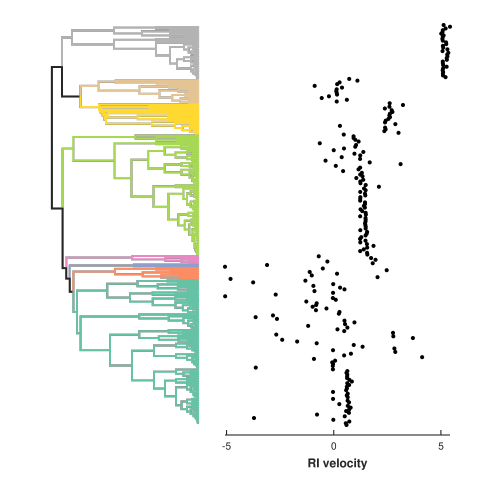

In [99]:
tree_rates, (rax0, rax1) = plot_tree_rates(TREE, crowns, psi_means);

In [100]:
toyplot.png.render(tree_rates, "/home/henry/png/tree_rates.png")

In [70]:
for idx in range(len(names)):
    print(names[idx], linear['trace']['𝜓'].mean(axis=0)[idx])

Quercus arizonica 0.5949893947674075
Quercus oblongifolia 0.5616774457382259
Quercus laeta 0.7260959008051231
Quercus ajoensis -0.019978672364844696
Quercus turbinella -3.720331396641285
Quercus toumeyi 0.5132870280953693
Quercus grisea -0.779004505431273
Quercus striatula 0.7089044297406847
Quercus chihuahuensis 0.5780955879951374
Quercus diversifolia 0.7227327158187509
Quercus glaucoides 0.7890679725104136
Quercus deserticola 0.6546477749194348
Quercus obtusata 0.2600669997106111
Quercus potosina 0.7134498985732536
Quercus peduncularis 0.6470894695384586
Quercus nudinervis -0.032060932404248815
Quercus subspathulata 0.6516374675868617
Quercus resinosa 0.6088349224265642
Quercus magnoliifolia 0.6528396071176712
Quercus purulhana -0.03367221325758578
Quercus segoviensis 0.5778393602820605
Quercus liebmanii 0.6134805360051723
Quercus glaucescens 0.6117757157490974
Quercus glabrescens 0.7173286489451662
Quercus martinezii 0.6314037928091606
Quercus rugosa 0.8448889623346525
Quercus gregg

Quercus kerrii 5.126050796485495
Quercus austrocochinchinensis 5.014855559152951
Quercus rex 5.074548202984535
Quercus chungii 5.089360350130979
Quercus delavayi 5.219512523763145
Quercus championii 5.423507322410551
Quercus gilva 5.124788745320693


### Compare rates to ecological traits

In [71]:
names = ["Quercus " + TREE.get_tip_labels()[idx].split("|")[-1].split(".")[-1] for idx in range(len(TREE.get_tip_labels()))]

In [76]:
import sproc
ranges = [sproc.Sproc(idx, workdir = "/tmp") for idx in names]

04:51 | INFO    | __init__        | fetched 500 occurrence records
04:52 | INFO    | _mark_outliers  | dropped outliers: 108
04:52 | INFO    | write           | wrote data to /tmp/Quercus_arizonica.json
04:52 | INFO    | __init__        | fetched 310 occurrence records
04:52 | INFO    | _mark_outliers  | dropped outliers: 62
04:52 | INFO    | write           | wrote data to /tmp/Quercus_oblongifolia.json
04:52 | INFO    | __init__        | fetched 1537 occurrence records
04:52 | INFO    | _mark_outliers  | dropped outliers: 192
04:52 | INFO    | write           | wrote data to /tmp/Quercus_laeta.json
04:52 | INFO    | __init__        | fetched 45 occurrence records
04:52 | INFO    | _mark_outliers  | dropped outliers: 0
04:52 | INFO    | write           | wrote data to /tmp/Quercus_ajoensis.json
04:52 | INFO    | __init__        | fetched 1175 occurrence records
04:52 | INFO    | _mark_outliers  | dropped outliers: 15
04:52 | INFO    | write           | wrote data to /tmp/Quercus_turbi

04:54 | INFO    | _mark_outliers  | dropped outliers: 28
04:54 | INFO    | write           | wrote data to /tmp/Quercus_insignis.json
04:54 | INFO    | __init__        | fetched 573 occurrence records
04:54 | INFO    | _mark_outliers  | dropped outliers: 56
04:54 | INFO    | write           | wrote data to /tmp/Quercus_lancifolia.json
04:54 | INFO    | __init__        | fetched 103 occurrence records
04:54 | INFO    | _mark_outliers  | dropped outliers: 0
04:54 | INFO    | write           | wrote data to /tmp/Quercus_copeyensis.json
04:54 | INFO    | __init__        | fetched 392 occurrence records
04:54 | INFO    | _mark_outliers  | dropped outliers: 4
04:54 | INFO    | write           | wrote data to /tmp/Quercus_germana.json
04:54 | INFO    | __init__        | fetched 7 occurrence records
04:54 | INFO    | _mark_outliers  | dropped outliers: 0
04:54 | INFO    | write           | wrote data to /tmp/Quercus_boyntonii.json
04:54 | INFO    | __init__        | fetched 918 occurrence reco

04:56 | INFO    | __init__        | fetched 653 occurrence records
04:56 | INFO    | _mark_outliers  | dropped outliers: 12
04:56 | INFO    | write           | wrote data to /tmp/Quercus_douglasii.json
04:56 | INFO    | __init__        | fetched 355 occurrence records
04:56 | INFO    | _mark_outliers  | dropped outliers: 0
04:56 | INFO    | write           | wrote data to /tmp/Quercus_john-tuckeri.json
04:56 | INFO    | __init__        | fetched 1131 occurrence records
04:56 | INFO    | _mark_outliers  | dropped outliers: 6
04:56 | INFO    | write           | wrote data to /tmp/Quercus_berberidifolia.json
04:56 | INFO    | __init__        | fetched 766 occurrence records
04:56 | INFO    | _mark_outliers  | dropped outliers: 290
04:56 | INFO    | write           | wrote data to /tmp/Quercus_durata.json
04:56 | INFO    | __init__        | fetched 1056 occurrence records
04:56 | INFO    | _mark_outliers  | dropped outliers: 5
04:56 | INFO    | write           | wrote data to /tmp/Quercus_

04:59 | INFO    | _mark_outliers  | dropped outliers: 4
04:59 | INFO    | write           | wrote data to /tmp/Quercus_geminata.json
05:00 | INFO    | __init__        | fetched 82 occurrence records
05:00 | INFO    | _mark_outliers  | dropped outliers: 2
05:00 | INFO    | write           | wrote data to /tmp/Quercus_minima.json
05:00 | INFO    | __init__        | fetched 875 occurrence records
05:00 | INFO    | _mark_outliers  | dropped outliers: 30
05:00 | INFO    | write           | wrote data to /tmp/Quercus_oleoides.json
05:00 | INFO    | __init__        | fetched 28 occurrence records
05:00 | INFO    | _mark_outliers  | dropped outliers: 0
05:00 | INFO    | write           | wrote data to /tmp/Quercus_cubana.json
05:00 | INFO    | __init__        | fetched 105 occurrence records
05:00 | INFO    | _mark_outliers  | dropped outliers: 1
05:00 | INFO    | write           | wrote data to /tmp/Quercus_brandegeei.json
05:00 | INFO    | __init__        | fetched 171 occurrence records
05:

05:01 | INFO    | __init__        | fetched 978 occurrence records
05:01 | INFO    | _mark_outliers  | dropped outliers: 7
05:01 | INFO    | write           | wrote data to /tmp/Quercus_crassipes.json
05:02 | INFO    | __init__        | fetched 252 occurrence records
05:02 | INFO    | _mark_outliers  | dropped outliers: 1
05:02 | INFO    | write           | wrote data to /tmp/Quercus_gentryi.json
05:02 | INFO    | __init__        | fetched 2448 occurrence records
05:02 | INFO    | _mark_outliers  | dropped outliers: 130
05:02 | INFO    | write           | wrote data to /tmp/Quercus_castanea.json
05:02 | INFO    | __init__        | fetched 116 occurrence records
05:02 | INFO    | _mark_outliers  | dropped outliers: 0
05:02 | INFO    | write           | wrote data to /tmp/Quercus_grahamii.json
05:02 | INFO    | __init__        | fetched 1187 occurrence records
05:02 | INFO    | _mark_outliers  | dropped outliers: 20
05:02 | INFO    | write           | wrote data to /tmp/Quercus_acutifoli

05:03 | INFO    | write           | wrote data to /tmp/Quercus_nigra.json
05:03 | INFO    | __init__        | fetched 129 occurrence records
05:03 | INFO    | _mark_outliers  | dropped outliers: 27
05:03 | INFO    | write           | wrote data to /tmp/Quercus_incana.json
05:03 | INFO    | __init__        | fetched 82 occurrence records
05:03 | INFO    | _mark_outliers  | dropped outliers: 16
05:03 | INFO    | write           | wrote data to /tmp/Quercus_hemisphaerica.json
05:04 | INFO    | __init__        | fetched 128 occurrence records
05:04 | INFO    | _mark_outliers  | dropped outliers: 24
05:04 | INFO    | write           | wrote data to /tmp/Quercus_laevis.json
05:04 | INFO    | __init__        | fetched 682 occurrence records
05:04 | INFO    | _mark_outliers  | dropped outliers: 286
05:04 | INFO    | write           | wrote data to /tmp/Quercus_marilandica.json
05:04 | INFO    | __init__        | fetched 647 occurrence records
05:04 | INFO    | _mark_outliers  | dropped outlier

05:06 | INFO    | _mark_outliers  | dropped outliers: 0
05:06 | INFO    | write           | wrote data to /tmp/Quercus_alnifolia.json
05:06 | INFO    | __init__        | fetched 2289 occurrence records
05:06 | INFO    | _mark_outliers  | dropped outliers: 288
05:06 | INFO    | write           | wrote data to /tmp/Quercus_ilex.json
05:06 | INFO    | __init__        | fetched 1626 occurrence records
05:06 | INFO    | _mark_outliers  | dropped outliers: 1007
05:06 | INFO    | write           | wrote data to /tmp/Quercus_rotundifolia.json
05:06 | INFO    | __init__        | fetched 65 occurrence records
05:06 | INFO    | _mark_outliers  | dropped outliers: 0
05:06 | INFO    | write           | wrote data to /tmp/Quercus_baloot.json
05:06 | INFO    | __init__        | fetched 51 occurrence records
05:06 | INFO    | _mark_outliers  | dropped outliers: 13
05:06 | INFO    | write           | wrote data to /tmp/Quercus_floribunda.json
05:06 | INFO    | __init__        | fetched 165 occurrence r

05:07 | INFO    | __init__        | fetched 151 occurrence records
05:07 | INFO    | _mark_outliers  | dropped outliers: 3
05:07 | INFO    | write           | wrote data to /tmp/Quercus_blakei.json
05:07 | INFO    | __init__        | fetched 50 occurrence records
05:07 | INFO    | _mark_outliers  | dropped outliers: 0
05:07 | INFO    | write           | wrote data to /tmp/Quercus_phanera.json
05:07 | INFO    | __init__        | fetched 38 occurrence records
05:07 | INFO    | _mark_outliers  | dropped outliers: 0
05:07 | INFO    | write           | wrote data to /tmp/Quercus_bella.json
05:07 | INFO    | __init__        | fetched 32 occurrence records
05:07 | INFO    | _mark_outliers  | dropped outliers: 3
05:07 | INFO    | write           | wrote data to /tmp/Quercus_chapensis.json
05:07 | INFO    | __init__        | fetched 63 occurrence records
05:07 | INFO    | _mark_outliers  | dropped outliers: 1
05:07 | INFO    | write           | wrote data to /tmp/Quercus_langbianensis.json
05:0

05:08 | INFO    | write           | wrote data to /tmp/Quercus_delavayi.json
05:09 | INFO    | __init__        | fetched 167 occurrence records
05:09 | INFO    | _mark_outliers  | dropped outliers: 0
05:09 | INFO    | write           | wrote data to /tmp/Quercus_championii.json
05:09 | INFO    | __init__        | fetched 263 occurrence records
05:09 | INFO    | _mark_outliers  | dropped outliers: 102
05:09 | INFO    | write           | wrote data to /tmp/Quercus_gilva.json


In [77]:
sizes = [idx.georange.area for idx in ranges]
counts = [idx.occs for idx in ranges]

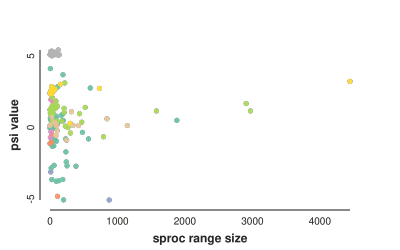

In [78]:
c, a, m = toyplot.scatterplot(
    sizes,
    linear['trace']['𝜓'].mean(axis=0),
    width=400,
    height=250,
    xlabel="sproc range size",
    ylabel="psi value",
    color=[toyplot.color.Palette()[i] for i in gidx],
);

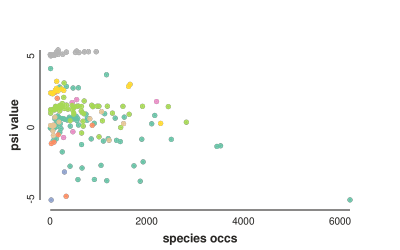

In [79]:
c, a, m = toyplot.scatterplot(
    counts,
    linear['trace']['𝜓'].mean(axis=0),
    width=400,
    height=250,
    xlabel="species occs",
    ylabel="psi value",
    color=[toyplot.color.Palette()[i] for i in gidx],
);

In [80]:
ftchart = pd.read_csv("/home/henry/oaks-thesis/csv-files/flowering-time-chart.csv",
                     usecols = ['names', 'psi (y1/y2)', 'FT1 (x1)', 'FT2 (x2)', 'gidx']).dropna().reset_index(drop = True)

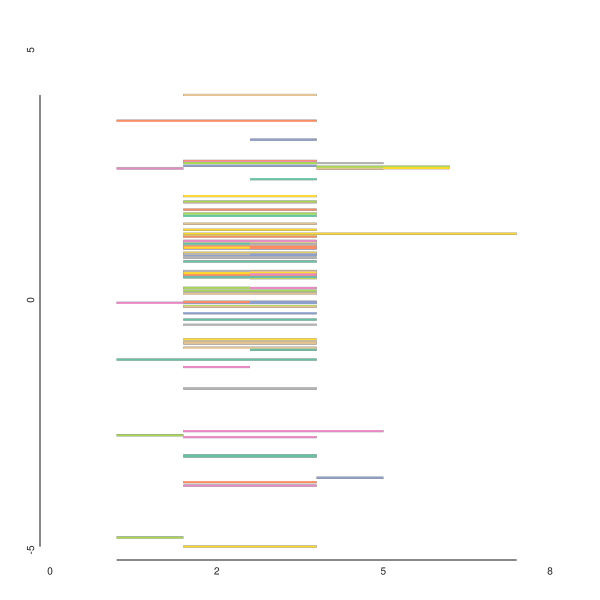

In [81]:
canvas = toyplot.Canvas()
axes = canvas.cartesian()
marks = []
for idx in ftchart.index:
    line = axes.plot([ftchart.loc[idx, "FT1 (x1)"], ftchart.loc[idx, "FT2 (x2)"]], 
              [ftchart.loc[idx, "psi (y1/y2)"], ftchart.loc[idx, "psi (y1/y2)"]])
    marks.append(line)

### Earth Engine

### Models with normalized distances

In [107]:
# model input
normdist_args = [
    data.normdist,
    data.RI,
    data.sidx0,
    data.sidx1,
    gidx,
]

In [121]:
linear_norm = partpooled_linear(*normdist_args, **sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝛼, 𝛽, 𝜓_offset, 𝜓_std, 𝜓_mean]


RuntimeError: Chain 0 failed.

In [118]:
logarithmic_norm = partpooled_logarithmic(*normdist_args, **sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝛼, 𝛽, 𝜓_offset, 𝜓_std, 𝜓_mean]


/home/henry/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/henry/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/henry/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
y   -inf


ParallelSamplingError: Bad initial energy

/home/henry/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [120]:
exponential_norm = partpooled_exponential(*normdist_args, **sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝛼, 𝛽, 𝜓_offset, 𝜓_std, 𝜓_mean]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 4713 seconds.
There were 9997 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9984 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9996 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9974 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [119]:
asymptotic_norm = partpooled_asymptotic(*normdist_args, **sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝛼, 𝛽, 𝜓_offset, 𝜓_std, 𝜓_mean]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 19760 seconds.
There were 1298 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1549 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9516529102065884, but should be close to 0.99. Try to increase the number of tuning steps.
There were 1327 divergences after tuning. Increase `target_accept` or reparameterize.
There were 947 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [114]:
quadratic_norm = partpooled_quadratic(*normdist_args, **sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝛼, 𝛽, 𝜓_offset, 𝜓_std, 𝜓_mean]


RuntimeError: Chain 2 failed.